In [1]:
import os
import sys
sys.path.append(os.chdir('../../'))

In [2]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import datetime

import matplotlib.pyplot as plt
import plotly.plotly as ply
import plotly.graph_objs as go
import src.utils.graph as graph
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

#from sklearn.multioutput import MultiOutputRegressor
from src.algorithms.multioutput import MultiOutputRegressor, RegressorChain

from sklearn.utils import shuffle
#from catboost import CatBoostRegressor
from src.algorithms.catboost_model import CatBoost

from sklearn.metrics import mean_absolute_error

tqdm.pandas()
pd.options.display.max_columns = None
pd.options.display.max_colwidth = -1

import src.data as data
import src.utility as utility

/Users/federico/miniconda3/envs/recsys/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/federico/miniconda3/envs/recsys/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [4]:
#dataset_train = base_df.merge(data.base_dataset(), how='left')
X, Y = data.dataset('local', 'train', onehot=False, drop_index_columns=True)

caching resources/dataset/preprocessed/local/train/merged_dataset.csv.gz


In [3]:
#path = os.path.join(f'resources/dataset/preprocessed/base_dataframe_train_inferred.csv.gz')
#dataset = pd.read_csv(path, parse_dates=True, index_col=0)
#X, Y = data.dataset_interpolated('train', onehot=False)

In [5]:
X.head(4)

,EMERGENCY_LANE,LANES,ROAD_TYPE,EVENT_DETAIL,EVENT_TYPE,distance_start,distance_end,SPEED_AVG_-4,SPEED_AVG_-3,SPEED_AVG_-2,SPEED_AVG_-1,SPEED_SD_-4,SPEED_SD_-3,SPEED_SD_-2,SPEED_SD_-1,SPEED_MAX_-4,SPEED_MAX_-3,SPEED_MAX_-2,SPEED_MAX_-1,SPEED_MIN_-4,SPEED_MIN_-3,SPEED_MIN_-2,SPEED_MIN_-1,N_VEHICLES_-4,N_VEHICLES_-3,N_VEHICLES_-2,N_VEHICLES_-1,WEATHER_-4,WEATHER_-3,WEATHER_-2,WEATHER_-1,DISTANCE_-4,DISTANCE_-3,DISTANCE_-2,DISTANCE_-1,TEMPERATURE_-4,TEMPERATURE_-3,TEMPERATURE_-2,TEMPERATURE_-1,MIN_TEMPERATURE_-4,MIN_TEMPERATURE_-3,MIN_TEMPERATURE_-2,MIN_TEMPERATURE_-1,MAX_TEMPERATURE_-4,MAX_TEMPERATURE_-3,MAX_TEMPERATURE_-2,MAX_TEMPERATURE_-1,avg_speed_street,avg_speed_sd_street,avg_speed_min_street,avg_speed_max_street,avg_n_vehicles_street,avg_speed_sensor,avg_speed_sd_sensor,avg_speed_min_sensor,avg_speed_max_sensor,avg_n_vehicles_sensor,avg_speed_sensor_hour_y_0,avg_speed_sd_sensor_hour_y_0,avg_speed_min_sensor_hour_y_0,avg_speed_max_sensor_hour_y_0,avg_n_vehicles_sensor_hour_y_0,avg_speed_sensor_hour_y_1,avg_speed_sd_sensor_hour_y_1,avg_speed_min_sensor_hour_y_1,avg_speed_max_sensor_hour_y_1,avg_n_vehicles_sensor_hour_y_1,avg_speed_sensor_hour_y_2,avg_speed_sd_sensor_hour_y_2,avg_speed_min_sensor_hour_y_2,avg_speed_max_sensor_hour_y_2,avg_n_vehicles_sensor_hour_y_2,avg_speed_sensor_hour_y_3,avg_speed_sd_sensor_hour_y_3,avg_speed_min_sensor_hour_y_3,avg_speed_max_sensor_hour_y_3,avg_n_vehicles_sensor_hour_y_3,avg_speed_roadtype,avg_speed_roadtype_event,avg_speed_sd_roadtype_event,avg_speed_min_roadtype_event,avg_speed_max_roadtype_event,avg_n_vehicles_roadtype_event,SPEED_AVG_1_DAY_BEFORE,SPEED_SD_1_DAY_BEFORE,SPEED_MIN_1_DAY_BEFORE,SPEED_MAX_1_DAY_BEFORE,N_VEHICLES_1_DAY_BEFORE,SPEED_AVG_2_DAY_BEFORE,SPEED_SD_2_DAY_BEFORE,SPEED_MIN_2_DAY_BEFORE,SPEED_MAX_2_DAY_BEFORE,N_VEHICLES_2_DAY_BEFORE,WEATHER_-4_CL,WEATHER_-3_CL,WEATHER_-2_CL,WEATHER_-1_CL,avg_n_vehicles_sensor_per_day,WEEK_DAY,IS_WEEKEND
12804,0,1,0,5,Ostacolo_in_carreggiata,23,-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195.054774,22.474385,160.665414,244.603597,31.606994,199.483045,24.219031,165.123653,246.304907,18.509316,203.517419,25.712245,162.990099,257.810248,21.347107,200.420731,23.970408,164.624869,250.378869,18.950820,197.435316,23.747478,160.473770,247.129607,18.975410,197.012560,23.168213,160.075902,244.198639,20.065574,179.336624,166.703860,20.017264,128.401572,208.577886,51.273795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.676946,NaN,NaN
4185,0,2,0,26,Pavimentazione,1,-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.155881,28.316264,143.185831,272.268567,92.172817,197.367344,25.871607,130.451526,270.412245,163.021798,198.659748,25.343918,128.710574,276.651475,216.024590,198.287926,25.714196,122.941475,277.513525,215.188525,197.624644,25.543851,118.193574,276.717787,214.737705,196.029496,24.904939,120.739934,272.778885,217.122951,179.336624,176.361282,20.930058,132.589827,233.054348,84.198646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,178.448511,NaN,NaN
4186,0,2,0,26,Pavimentazione,2,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.155881,28.316264,143.185831,272.268567,92.172817,176.171896,20.513239,118.042177,226.553544,132.162927,179.088246,15.649102,122.849610,228.808878,188.048780,170.920929,15.765408,111.563073,218.035366,188.731707,170.251706,16.397801,96.473250,218.794050,198.625000,166.814832,17.984078,107.866667,220.009476,194.666667,179.336624,176.361282,20.930058,132.589827,233.054348,84.198646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.522727,NaN,NaN
4187,0,2,0,26,Pavimentazione,3,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [4]:
print(X.shape)
print(Y.shape)
print()
print(Y.dtypes)

(33202, 77)
(33202, 4)

SPEED_AVG_Y_0    float64
SPEED_AVG_Y_1    float64
SPEED_AVG_Y_2    float64
SPEED_AVG_Y_3    float64
dtype: object


## Preprocess data

In [4]:
X.head(10)

,EMERGENCY_LANE,LANES,ROAD_TYPE,EVENT_DETAIL,EVENT_TYPE,SPEED_AVG_-4,SPEED_AVG_-3,SPEED_AVG_-2,SPEED_AVG_-1,SPEED_SD_-4,SPEED_SD_-3,SPEED_SD_-2,SPEED_SD_-1,SPEED_MAX_-4,SPEED_MAX_-3,SPEED_MAX_-2,SPEED_MAX_-1,SPEED_MIN_-4,SPEED_MIN_-3,SPEED_MIN_-2,SPEED_MIN_-1,N_VEHICLES_-4,N_VEHICLES_-3,N_VEHICLES_-2,N_VEHICLES_-1,WEATHER_-4,WEATHER_-3,WEATHER_-2,WEATHER_-1,DISTANCE_-4,DISTANCE_-3,DISTANCE_-2,DISTANCE_-1,TEMPERATURE_-4,TEMPERATURE_-3,TEMPERATURE_-2,TEMPERATURE_-1,MIN_TEMPERATURE_-4,MIN_TEMPERATURE_-3,MIN_TEMPERATURE_-2,MIN_TEMPERATURE_-1,MAX_TEMPERATURE_-4,MAX_TEMPERATURE_-3,MAX_TEMPERATURE_-2,MAX_TEMPERATURE_-1
0,1,2,1,11,Veicolo_in_avaria,NaN,199.6642,199.3150,204.7759,NaN,41.4457,52.0643,43.0659,NaN,263.734,292.858,294.476,NaN,59.866,59.866,59.866,NaN,107.0,129.0,139.0,NaN,Quasi Sereno,Quasi Sereno,Quasi Sereno,NaN,38.0,38.0,38.0,NaN,28.0,28.0,28.0,NaN,21.0,21.0,21.0,NaN,29.0,29.0,29.0
1,1,2,1,6,Gestione_viabilita,NaN,NaN,NaN,208.9124,NaN,NaN,NaN,38.8807,NaN,NaN,NaN,352.724,NaN,NaN,NaN,59.866,NaN,NaN,NaN,238.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,1,6,Gestione_viabilita,NaN,NaN,208.9124,201.9654,NaN,NaN,38.8807,39.7029,NaN,NaN,352.724,286.386,NaN,NaN,59.866,59.866,NaN,NaN,238.0,216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2,1,6,Gestione_viabilita,NaN,NaN,NaN,213.5957,NaN,NaN,NaN,35.7280,NaN,NaN,NaN,334.926,NaN,NaN,NaN,59.866,NaN,NaN,NaN,246.0,NaN,NaN,NaN,Rovescio Nelle Vicinanze con Pioggia,NaN,NaN,NaN,38.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,19.0,NaN,NaN,NaN,21.0
4,1,2,1,2,Manutenzione_opere_in_verde,210.7883,213.6824,223.9108,223.1689,34.5211,33.1529,32.9331,30.7040,281.532,343.016,389.938,341.398,59.866,61.484,64.720,59.866,231.0,228.0,222.0,239.0,Quasi Sereno,Quasi Sereno,Quasi Sereno,Quasi Sereno,226.0,226.0,38.0,38.0,21.0,21.0,19.0,19.0,10.0,10.0,12.0,12.0,21.0,21.0,19.0,19.0
5,1,2,1,2,Manutenzione_opere_in_verde,223.1689,218.5277,219.2802,214.6672,30.7040,29.5927,28.9895,32.1558,341.398,328.454,300.948,286.386,59.866,59.866,61.484,59.866,239.0,265.0,255.0,258.0,Quasi Sereno,Quasi Sereno,Quasi Sereno,Quasi Sereno,38.0,38.0,38.0,38.0,19.0,19.0,19.0,19.0,12.0,12.0,12.0,12.0,19.0,19.0,19.0,19.0
6,1,2,1,2,Manutenzione_opere_in_verde,218.5277,219.2802,214.6672,216.8678,29.5927,28.9895,32.1558,29.6041,328.454,300.948,286.386,310.656,59.866,61.484,59.866,59.866,265.0,255.0,258.0,232.0,Quasi Sereno,Quasi Sereno,Quasi Sereno,Quasi Sereno,38.0,38.0,38.0,38.0,19.0,19.0,19.0,19.0,12.0,12.0,12.0,12.0,19.0,19.0,19.0,19.0
7,1,2,1,11,Veicolo_in_avaria,NaN,NaN,199.6642,199.3150,NaN,NaN,41.4457,52.0643,NaN,NaN,263.734,292.858,NaN,NaN,59.866,59.866,NaN,NaN,107.0,129.0,NaN,NaN,Quasi Sereno,Quasi Sereno,NaN,NaN,38.0,38.0,NaN,NaN,28.0,28.0,NaN,NaN,21.0,21.0,NaN,NaN,29.0,29.0
8,1,2,1,2,Manutenzione_opere_in_verde,NaN,216.4407,208.1131,217.6035,NaN,44.8391,42.4317,37.3565,NaN,368.904,281.532,349.488,NaN,59.866,59.866,59.866,NaN,183.0,186.0,231.0,NaN,Quasi Sereno,Quasi Sereno,Quasi Sereno,NaN,38.0,38.0,38.0,NaN,12.0,12.0,14.0,NaN,13.0,13.0,12.0,NaN,14.0,14.0,14.0
9,1,2,1,2,Manutenzione_opere_in_verde,211.3166,212.3555,207.6177,213.4945,27.7924,37.2444,34.9689,33.5346,278.296,307.420,273.442,296.094,61.484,59.866,59.866,59.866,280.0,232.0,274.0,258.0,Quasi Sereno,Quasi Sereno,Quasi Sereno,Quasi Sereno,38.0,38.0,226.0,226.0,15.0,15.0,17.0,17.0,12.0,12.0,10.0,10.0,14.0,14.0,15.0,15.0


In [7]:
# add features
import src.preprocessing.other_features as feat
avg_speed_road_event = feat.avg_speed_for_roadtype_event()
X = X.merge(avg_speed_road_event, how='left', on=['EVENT_TYPE','ROAD_TYPE'])

avg_speed_road_event.head()

In [4]:
X.fillna(0, inplace=True)
#Y.fillna(0, inplace=True)

weather_cols = [col for col in X.columns if col.startswith('WEATHER_')]
categorical_cols = ['EMERGENCY_LANE', 'ROAD_TYPE', 'EVENT_DETAIL','EVENT_TYPE',] + weather_cols

## Train/Validation split

In [12]:
#X, Y = shuffle(X, Y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [6]:
def evaluate(model, X_test, y_test):
    mask_test = np.all(y_test.notnull(), axis=1)
    print('number of valid samples:', (mask_test*1).sum())

    y_pred = model.predict(X_test[mask_test])
    return mean_absolute_error(y_test[mask_test], y_pred)

## Fit

In [ ]:
from catboost import CatBoostRegressor

mae = []
for colY in Y.columns:
    mask = Y[colY].notnull()
    x = X_train[mask]
    y = y_train[colY][mask]
    
    mask_val = y_test[colY].notnull()
    x_val = X_test[mask]
    y_val = y_test[colY][mask_val]
    
    catboost = CatBoostRegressor(**{
        'loss_function': 'MAE',
        'eval_metric': 'MAE',
        'iterations':2000,
        'depth':6,
        'learning_rate':1,
        'early_stopping_rounds': 80,
        'cat_features': categorical_cols,
        'verbose': True
    })
    
    catboost.fit(x, y, eval_set=[(x_val, y_val)])
    
    # evaluate
    y_pred = catboost.predict(x_val)
    
    mae.append( mean_absolute_error(y_val, y_pred) )

In [18]:
mae

[6.6273399128792825, 7.877166646134302, 9.378274779374266, 10.505643840577255]

In [22]:
sum(mae)/4

8.597106294741277

In [6]:
catboost = CatBoost(params_dict={
    'X': X,
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'iterations':2,
    'depth':6,
    'learning_rate':1,
    'cat_features': categorical_cols,
    'verbose': False
})

In [8]:
model = RegressorChain(catboost)
model.fit(X, Y)

catboost: fitting...
catboost: fitting...
catboost: fitting...
catboost: fitting...


RegressorChain(base_estimator=<src.algorithms.catboost_model.CatBoost object at 0x1a20daf3c8>,
        cv=None, order=None, random_state=None)

In [11]:
evaluate(X_test, y_test)

7.8075137571574285

## Test model

In [3]:
import src.algorithms.inout as inout

In [4]:
X, Y = data.dataset('local', 'test', onehot=False, drop_index_columns=True)
#X.fillna(0, inplace=True)
weather_cols = ['WEATHER_-4','WEATHER_-3','WEATHER_-2','WEATHER_-1']
X[weather_cols] = X[weather_cols].fillna('Unknown')

weather_clusters_cols = ['WEATHER_-4_CL','WEATHER_-3_CL','WEATHER_-2_CL','WEATHER_-1_CL']
X[weather_clusters_cols] = X[weather_clusters_cols].fillna('Unknown')

X.shape

caching resources/dataset/preprocessed/local/test/merged_dataset.csv.gz


(5861, 98)

In [5]:
X.head()

,EMERGENCY_LANE,LANES,ROAD_TYPE,EVENT_DETAIL,EVENT_TYPE,SPEED_AVG_-4,SPEED_AVG_-3,SPEED_AVG_-2,SPEED_AVG_-1,SPEED_SD_-4,SPEED_SD_-3,SPEED_SD_-2,SPEED_SD_-1,SPEED_MAX_-4,SPEED_MAX_-3,SPEED_MAX_-2,SPEED_MAX_-1,SPEED_MIN_-4,SPEED_MIN_-3,SPEED_MIN_-2,SPEED_MIN_-1,N_VEHICLES_-4,N_VEHICLES_-3,N_VEHICLES_-2,N_VEHICLES_-1,WEATHER_-4,WEATHER_-3,WEATHER_-2,WEATHER_-1,DISTANCE_-4,DISTANCE_-3,DISTANCE_-2,DISTANCE_-1,TEMPERATURE_-4,TEMPERATURE_-3,TEMPERATURE_-2,TEMPERATURE_-1,MIN_TEMPERATURE_-4,MIN_TEMPERATURE_-3,MIN_TEMPERATURE_-2,MIN_TEMPERATURE_-1,MAX_TEMPERATURE_-4,MAX_TEMPERATURE_-3,MAX_TEMPERATURE_-2,MAX_TEMPERATURE_-1,avg_speed_street,avg_speed_sd_street,avg_speed_min_street,avg_speed_max_street,avg_n_vehicles_street,avg_speed_sensor,avg_speed_sd_sensor,avg_speed_min_sensor,avg_speed_max_sensor,avg_n_vehicles_sensor,avg_speed_sensor_hour_y_0,avg_speed_sd_sensor_hour_y_0,avg_speed_min_sensor_hour_y_0,avg_speed_max_sensor_hour_y_0,avg_n_vehicles_sensor_hour_y_0,avg_speed_sensor_hour_y_1,avg_speed_sd_sensor_hour_y_1,avg_speed_min_sensor_hour_y_1,avg_speed_max_sensor_hour_y_1,avg_n_vehicles_sensor_hour_y_1,avg_speed_sensor_hour_y_2,avg_speed_sd_sensor_hour_y_2,avg_speed_min_sensor_hour_y_2,avg_speed_max_sensor_hour_y_2,avg_n_vehicles_sensor_hour_y_2,avg_speed_sensor_hour_y_3,avg_speed_sd_sensor_hour_y_3,avg_speed_min_sensor_hour_y_3,avg_speed_max_sensor_hour_y_3,avg_n_vehicles_sensor_hour_y_3,avg_speed_roadtype,avg_speed_roadtype_event,avg_speed_sd_roadtype_event,avg_speed_min_roadtype_event,avg_speed_max_roadtype_event,avg_n_vehicles_roadtype_event,SPEED_AVG_1_DAY_BEFORE,SPEED_SD_1_DAY_BEFORE,SPEED_MIN_1_DAY_BEFORE,SPEED_MAX_1_DAY_BEFORE,N_VEHICLES_1_DAY_BEFORE,SPEED_AVG_2_DAY_BEFORE,SPEED_SD_2_DAY_BEFORE,SPEED_MIN_2_DAY_BEFORE,SPEED_MAX_2_DAY_BEFORE,N_VEHICLES_2_DAY_BEFORE,WEATHER_-4_CL,WEATHER_-3_CL,WEATHER_-2_CL,WEATHER_-1_CL,avg_n_vehicles_sensor_per_day,WEEK_DAY,IS_WEEKEND
1907,0,1,0,29,Opera_arte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quasi Sereno,Quasi Sereno,Quasi Sereno,Quasi Sereno,40.0,40.0,40.0,40.0,23.0,23.0,23.0,22.0,12.0,12.0,12.0,12.0,23.0,23.0,23.0,23.0,163.819698,13.586373,147.090909,179.892182,5.363636,163.819698,13.586373,147.090909,179.892182,5.363636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.336624,171.783543,20.708429,124.997433,225.186464,72.236569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quasi Sereno,Quasi Sereno,Quasi Sereno,Quasi Sereno,9.500000,1,0
2615,0,1,0,24,Ostacolo_in_carreggiata,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Debole Pioggia,Quasi sereno,Quasi sereno,Quasi sereno,45.0,86.0,86.0,86.0,21.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,164.923955,19.734119,135.109704,196.741198,25.884426,162.017660,16.089150,130.721619,200.414382,55.117890,162.524473,16.182171,126.769642,201.815902,53.219512,163.367849,16.425346,127.493138,205.236065,56.341463,162.754604,16.091851,127.190585,205.788553,61.154472,162.318435,16.057377,125.177951,204.104780,64.910569,179.336624,166.703860,20.017264,128.401572,208.577886,51.273795,161.686456,15.177753,124.586,211.958,57.0,160.337151,15.250274,132.676,205.486,73.0,Debole Pioggia e Pioggrella,NaN,NaN,NaN,60.587024,4,0
4127,0,1,0,39,Calamita_naturale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Temporale con Debole Pioggia,Temporale con Debole Pioggia,Temporale con Debole Pioggia,Temporale con Debole Pioggia,50.0,50.0,50.0,50.0,20.0,20.0,20.0,20.0,18.0,18.0,18.0,18.0,24.0,24.0,24.0,24.0,168.997792,21.924146,132.002297,208.723132,22.147406,154.813661,21.918704,120.901806,185.014759,8.543491,151.005066,37.331542,94.812034,211.349521,10.948718,153.288699,40.018415,93.857712,215.564220,10.152542,149.833846,34.985699,93.695683,203.692717,9.925000,149.248294,36.353780,91.727117,203.530917,9.808333,179.336624,152.370992,20.729981,117.904507,192.326608,29.375547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Debole Pioggia e Piogg

In [5]:
#model = inout.load('saved_models/catboost_multiout_9.15091_with_nan.jl')
model = inout.load('saved_models/catboost_multiout_8.24623_features.jl')

Text(0.5, 0, 'Importance')

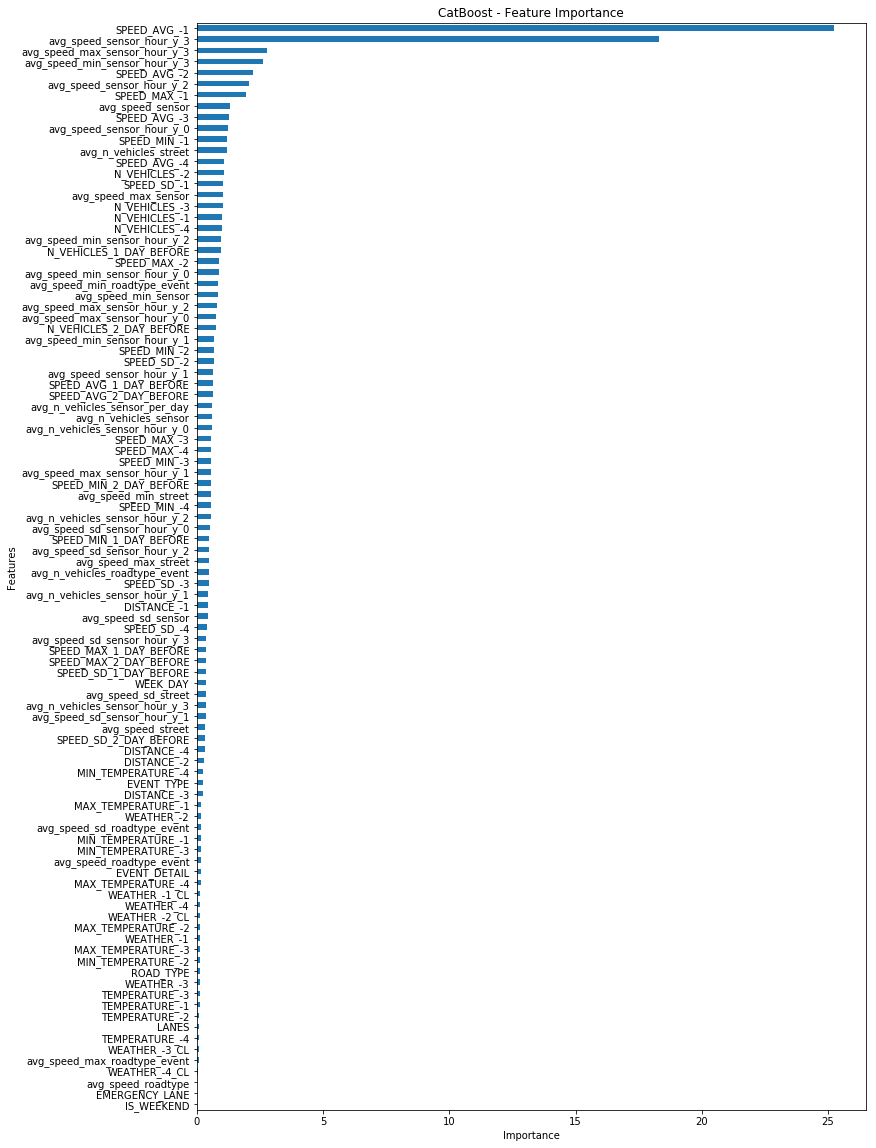

In [16]:
fea_imp = pd.DataFrame({'imp': model.estimators_[3].model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False])
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(12, 20), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [9]:
inout.evaluate(model, X_test=X, y_test=Y, intermediate=True)

This evaluation will be done for samples having ALL y not null!


(8.092034458990877,
 [6.845614056006739, 7.841027950946233, 8.606354071817021, 9.075141757193514])

In [10]:
sum(np.all(Y.notnull(), axis=1)*1)

2486

In [6]:
inout.evaluate(model, X_test=X, y_test=Y, intermediate=True)

This evaluation will be done for samples having ALL y not null!


(8.778172635987811,
 [7.596694319700774, 8.585476223174286, 9.246325107036673, 9.684194894039514])